# Set Up

In [1]:
# Mount Google Drive
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import os
import pandas as pd
import math
!pip install tweet-preprocessor

# Data

For our training, we have a few corpora to work with.
1. the CONAN datasets
2. the QIAN Benchmark dataset

First we read our corpora as raw dataframes with pandas.

---



In [6]:
# set data paths

root_dir = "gdrive/My Drive/Master_Thesis/"
data_dir = os.path.join(root_dir, 'data/')
Qian_gab_dir = os.path.join(data_dir, 'Qian/gab.csv')
Qian_reddit_dir = os.path.join(data_dir, 'Qian/reddit.csv')
CONAN_dir = os.path.join(data_dir, 'CONAN/CONAN.csv')
Multitarget_CONAN_dir = os.path.join(data_dir, 'Multitarget-CONAN/Multitarget-CONAN.csv')
DIALO_CONAN_dir = os.path.join(data_dir, 'DIALOCONAN/DIALOCONAN.csv')
KN_CONAN_dir = os.path.join(data_dir, 'multitarget_KN_grounded_CN/multitarget_KN_grounded_CN.csv')

EDOS_dir = os.path.join(data_dir, 'EDOS/edos_labelled_aggregated.csv')
SBIC_train_dir = os.path.join(data_dir, 'SBIC/SBIC.v2.agg.trn.csv')
SBIC_val_dir = os.path.join(data_dir, 'SBIC/SBIC.v2.agg.dev.csv')
SBIC_test_dir = os.path.join(data_dir, 'SBIC/SBIC.v2.agg.tst.csv')

In [7]:
# Read csv file into dataframe

raw_CONAN = pd.read_csv(CONAN_dir)
raw_MultiCONAN = pd.read_csv(Multitarget_CONAN_dir)
raw_DIALOCONAN = pd.read_csv(DIALO_CONAN_dir)
raw_KNCONAN = pd.read_csv(KN_CONAN_dir)

raw_Qian_gab = pd.read_csv(Qian_gab_dir)
raw_Qian_reddit = pd.read_csv(Qian_reddit_dir)

raw_EDOS = pd.read_csv(EDOS_dir)
raw_SBIC_train = pd.read_csv(SBIC_train_dir)
raw_SBIC_val = pd.read_csv(SBIC_val_dir)
raw_SBIC_test = pd.read_csv(SBIC_test_dir)

In [8]:
raw_Qian_gab.loc[0]['text']

"1. i joined gab to remind myself how retarded jew haters are. You wouldn't be typing on your abacus without them you retard.\n"

In [9]:
raw_Qian_gab

,id,text,hate_speech_idx,response
0,1. 39869714\n,1. i joined gab to remind myself how retarded ...,[1],"[""Using words that insult one group while defe..."
1,1. 39845588\n2. \t39848775\n3. \t\t39911017\n,1. This is what the left is really scared of. ...,[3],['You can disagree with someones opinion witho...
2,1. 37485560\n2. \t37528625\n,1. It makes you an asshole.\n2. \tGive it to a...,[2],['Your argument is more rational if you leave ...
3,1. 39787626\n2. \t39794481\n,1. So they manage to provide a whole lot of da...,[2],"[""You shouldn't generalize a specific group or..."
4,1. 37957930\n2. \t39953348\n3. \t\t39965219\n,"1. Hi there, i,m Keith, i hope you are doing w...",[3],['If someone is rude it is better to ignore th...
...,...,...,...,...
11820,1. 37556347\n2. \t37556710\n,1. Remember this 3 months ago? The intern that...,[2],['Using words that profanely refer to parts of...
11821,1. 38624662\n2. \t38624840\n,1. #Sweden's four major dailies aftonbladet.se...,[2],"['Hey there, derogatory comments are not produ..."
11822,1. 38361617\n2. \t38421472\n3. \t\t38422734\n,1. Satisfaction and justice\n2. \tBEST TRUMP I...,[3],['Using words that negatively describes someon...
11823,1. 38710847\n2. \t38711592\n3. \t\t38718122\n,1. Twitter BANNED me and reported me to the FB...,"[2, 3]","[""I don't think using words that are sexist in..."


## Data Cleaning
For fine-tuning GPT models (Causal Language Modeling), we concatenate the hate speech and the counter speech in one string with each begins with their prefix:
# **Hate-speech: "Text" Counter-speech: "Text"**

---
First, we convert all dataframes into the formate of

**{"Hate_Speech": hate_speech, "Counter_Speech": counter_speech, "Target": target}**

Then we concatenate the dataframes and perform further normalization steps

### Qian Benchmark Dataset
This dataset contains multiturn conversations and hate speech index, which indecate the hate speech segment inside the conversation, and the corresponding 3 response options.

For data cleaning, we first want to seperate the conversations into individual segments, and the responses into individual response.

Then, we take the hate-speech and response pair and concatenate them according to our defined data format.

Since there can be multiple hate-speech inside one conversation, and the dataset provides multiple responses for each conversation, we use combinatorial pairs to capture all possible combinations:

.

---

currently, this dataset is causing the model to perform in an undesired way. Therefore, we are not including it in our training and testing pipeline.

---



In [22]:
def Qian_preprocess(dataframe):
  # Some general preprocessing at first
  df = dataframe.copy()

  # Remove unwanted information
  df = df.drop("id", axis=1)

  # drop rows without hate speech
  df = df[df['hate_speech_idx'].notna()].reset_index()

  # remove square brackets
  df['hate_speech_idx'] = df['hate_speech_idx'].str.strip('[]')
  df['response'] = df['response'].str.strip('[]')

  # drop old index
  df = df.drop("index", axis=1)

  # split conversation segments into individual strings
  df['text'] = df['text'].str.split('\n')

  # split responses into individual strings
  df['response'] = df['response'].str.split(',')

  # split hate speech index into individual strings
  df['hate_speech_idx'] = df['hate_speech_idx'].str.split(',')

  return df

def Qian_clean(list_):
  # Text cleaning function, removes URLs, EMOJIs and extra whitespaces or special characters
  for idx, text in enumerate(list_):
    # pop element if it's empty (due to spliting with ",")
    if text == "":
      list_.pop()
    else:
      # remove the numbering, which are the first three characters
      list_[idx] = text[3:]


  return list_

def Qian_concatenate(df):
  # Create new dataframe with format "Hate-speech: "hatespeech text" Counter-speech: "counterspeech text", for each hate- and counter-speech pair
  n_entry = df.index.stop
  HATE_SPEECH = []
  COUNTER_SPEECH = []

  # go through each row in dataframe and check the number of hate speech and responses
  for idx in range(n_entry):
    # for each hate speech, concatenate each response as a pair
    for i, hate_idx in enumerate(df["hate_speech_idx"][idx]):
      if len(df["text"][idx]) < int(hate_idx):
        # Skip if the hate_speech_idx is wrong (outside of the given conversation, e.g. there're in total 14 segments, but the hate_idx is 20)
        pass

      else:
        hate_speech = df['text'][idx][int(hate_idx) - 1]
        for j, response in enumerate(df["response"][idx]):
          HATE_SPEECH.append(hate_speech)
          COUNTER_SPEECH.append(response)

  dic = {'Hate_Speech': HATE_SPEECH, 'Counter_Speech': COUNTER_SPEECH}
  df_new = pd.DataFrame(dic)

  return df_new

def Qian_pipeline(df_raw):
  df = Qian_preprocess(df_raw)
  df["text"].map(Qian_clean)
  df = Qian_concatenate(df)

  return df

In [36]:
df_Qian_gab = Qian_pipeline(raw_Qian_gab)
df_Qian_reddit = Qian_pipeline(raw_Qian_reddit)

In [37]:
df_Qian_gab

,Hate_Speech,Counter_Speech
0,i joined gab to remind myself how retarded jew...,"""Using words that insult one group while defen..."
1,i joined gab to remind myself how retarded jew...,'You can make the same point more effectively...
2,i joined gab to remind myself how retarded jew...,'Use of the r-word is unacceptable in our dis...
3,\t\tDumb Cunt,'You can disagree with someones opinion withou...
4,\t\tDumb Cunt,'You can make the same point more effectively...
...,...,...
54434,How absolutely unbelievably fascinating? A Pak...,"""Using words that derogatorily reference a par..."
54435,How absolutely unbelievably fascinating? A Pak...,'Hey there
54436,How absolutely unbelievably fascinating? A Pak...,sexist comments and views are rude and unwelc...
54437,How absolutely unbelievably fascinating? A Pak...,'Instead of just stating your opinion show pe...


### CONAN Dataset
This dataset contains single turn conversations with one hate-speech and its corresponding counter-speech in EN, FR and IT. We filter out the english language pairs and simply concatenate them into one to fit our format.



---

In [25]:
def CONAN_format(dataframe, language='EN'):
  df = dataframe[dataframe['cn_id'].str.startswith(language)]

  # drop old index
  df = df.drop("cn_id", axis=1)
  df = df.drop("cnType", axis=1)
  df = df.drop("age", axis=1)
  df = df.drop("gender", axis=1)
  df = df.drop("educationLevel", axis=1)
  df = df.rename(columns={"hateSpeech": "Hate_Speech", "counterSpeech": "Counter_Speech", "hsType": "Target", "hsSubType": "Target_2"})

  return df

### Multitarget CONAN Dataset
This dataset contains single turn conversations with one hate-speech and its corresponding counter-speech. We simply concatenate the pairs into one to fit our format.


---

In [26]:
def MultiCONAN_format(dataframe):
  # Remove unwanted information
  df = dataframe.drop("VERSION", axis=1)
  df = df.drop("INDEX", axis=1)

  df = df.rename(columns={"HATE_SPEECH": "Hate_Speech", "COUNTER_NARRATIVE": "Counter_Speech", "TARGET": "Target"})

  return df

### DIALO CONAN Dataset

The DIALOCONAN dataset contains multi-turn diaglogues with multiple hate-speech and counter-speech segments. Our application focuses on single turn hate- and counter-speech pairs, to avoid samples with incomplete context information, we only take the first turn of the each diaglogue conversation, since only the first turn is garanteed to contain complete context for themselves.


---

In [27]:
def DIALO_format(dataframe):
  hate_speech = []
  counter_speech = []
  target = []

  switch = 0

  max_idx = dataframe["dialogue_id"].max()+1

  for i in range(max_idx):
    # slice each diaglue as a sub-dataframe
    df = dataframe[(dataframe.dialogue_id == i)]

    for index, row in df.iterrows():
      if row["type"] == "HS" and switch == 0:
        hate_speech.append(row["text"])
        switch = 1
      elif row["type"] == "CN" and switch == 1:
        counter_speech.append(row["text"])
        target.append(row["TARGET"])
        switch = 0

        break

  data = {"Hate_Speech": hate_speech, "Counter_Speech": counter_speech, "Target": target}

  df_new = pd.DataFrame(data)
  return df_new

### EDOS - Explainable Detection of Online Sexism

In [28]:
df_EDOS = raw_EDOS.copy()
df_EDOS = df_EDOS[["text","label_sexist"]]
df_EDOS = df_EDOS.rename(columns={"label_sexist": "labels"})
df_EDOS_sexist = df_EDOS.loc[df_EDOS['labels'] == "sexist"]

In [31]:
df_EDOS

,text,labels
0,"In Nigeria, if you rape a woman, the men rape ...",not sexist
1,"Then, she's a keeper. 😉",not sexist
2,This is like the Metallica video where the poo...,not sexist
3,woman?,not sexist
4,I bet she wished she had a gun,not sexist
...,...,...
19995,girls really get fucked almost every weekend ?,not sexist
19996,The hatred for moslems are Reasonable and Just...,not sexist
19997,Now this is a woman who gets it. 👆,not sexist
19998,“American Idol” finalist [USER] said nothing i...,not sexist


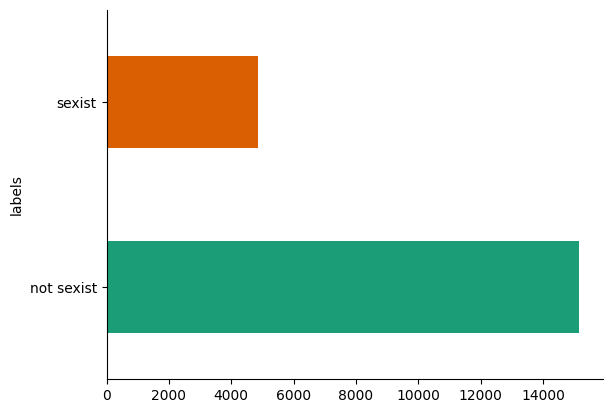

In [34]:
# @title labels

from matplotlib import pyplot as plt
import seaborn as sns
df_EDOS.groupby('labels').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

### SBIC - Social Bias Frame


In [29]:
def split_SBIC(df):
  tuple_head=[]
  for index,row in df.iterrows():
    tuple_temp=[row['post']]
    if "women" in row['targetMinority']:
      tuple_temp.append('sexist')
    else:
      tuple_temp.append('not sexist')
    tuple_head.append(tuple_temp)
  return pd.DataFrame(tuple_head,columns=['text','labels'])

In [30]:
SBIC_train = split_SBIC(raw_SBIC_train)
SBIC_val = split_SBIC(raw_SBIC_val)
SBIC_test = split_SBIC(raw_SBIC_test)

In [32]:
SBIC_train

,text,labels
0,"\n\nBill Kristol and Ben Shaprio, two turds in...",not sexist
1,\n\nRose\n🌹Taylor‏ @RealRoseTaylor 6h6 hours a...,not sexist
2,\nCharlie Kirk‏\n\nJohnny Depp calls for death...,not sexist
3,\nDavid Knight‏ \n\nNotice how quickly things ...,not sexist
4,\nFinland fireball: Time-lapse video shows nig...,not sexist
...,...,...
35419,👉 Illegally in the country after 5 deportation...,not sexist
35420,💥Breaking💥\nJulian Assange is the gate keeper ...,not sexist
35421,📖 2Kings 22:19 because your heart was peniten...,not sexist
35422,🚨#FAKENEWSAWARDS🚨\n\n🚨 who is #1 fake news ?🚨\...,not sexist


from matplotlib import pyplot as plt
import seaborn as sns
SBIC_train.groupby('labels').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

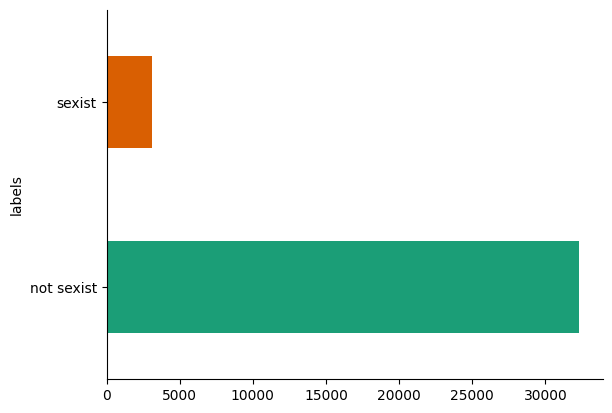

In [33]:
from matplotlib import pyplot as plt
import seaborn as sns
SBIC_train.groupby('labels').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

### Concatenate Dataframes and Text Normalization

In [35]:
df_CONAN = CONAN_format(raw_CONAN)
df_MultiCONAN = MultiCONAN_format(raw_MultiCONAN)
df_DIALOCONAN = DIALO_format(raw_DIALOCONAN)

In [38]:
# Convert labels into multiclass labels where each class is individually annotated with either 0 or 1
import numpy as np

types = df_MultiCONAN["Target"].unique()

df_MultiCONAN_sexist = df_MultiCONAN.copy()
for target in types:
  df_MultiCONAN_sexist[target] = np.where(df_MultiCONAN_sexist['Target']== target, 1, 0)

df_MultiCONAN_sexist_counter=df_MultiCONAN_sexist.drop("Hate_Speech", axis=1)
df_MultiCONAN_sexist_counter=df_MultiCONAN_sexist_counter.rename(columns={"Counter_Speech":"text", "Target":"TARGET"})

In [39]:
def format_multiclass(item):
  # Text cleaning function, removes URLs, EMOJIs and extra whitespaces or special characters
  return item.split("/")

df_temp = raw_DIALOCONAN.loc[raw_DIALOCONAN['type'] == "CN"]
types = ['MIGRANTS', 'POC', 'LGBT+', 'MUSLIMS', 'WOMEN', 'JEWS']
df_temp = df_temp.copy()
df_temp["TARGET"] = df_temp["TARGET"].map(format_multiclass)

tuple_head=[]
for index,row in df_temp.iterrows():
  tuple_temp=[row['text']]
  tuple_temp.append(row["TARGET"])
  for target in types:
    if target in row["TARGET"]:
      tuple_temp.append(1)
    else:
      tuple_temp.append(0)
  tuple_head.append(tuple_temp)

df_DIALOCONAN_sexist_counter=pd.DataFrame(tuple_head,columns=['text', "TARGET"] + (types))

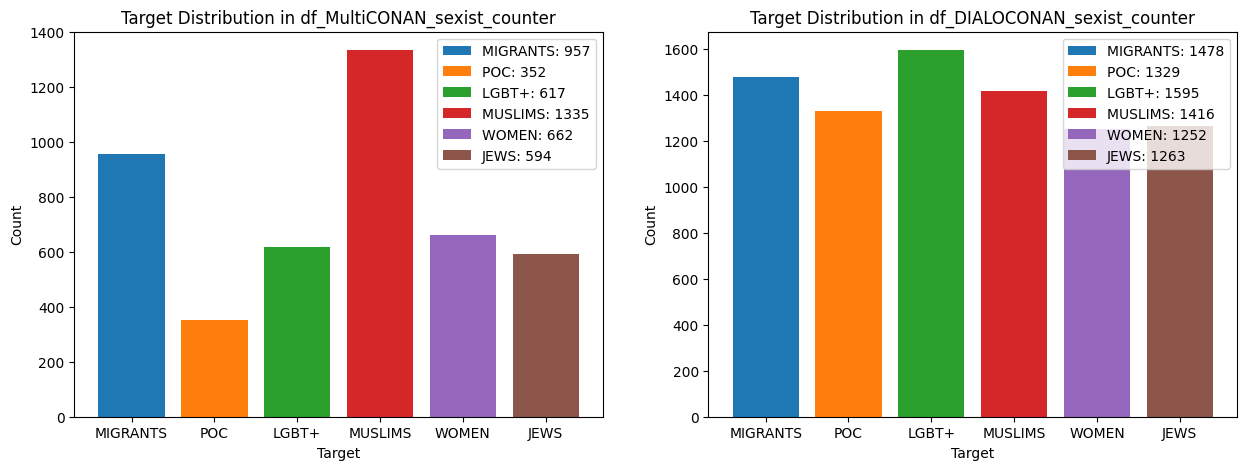

In [56]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot for df_MultiCONAN_sexist_counter
types = ['MIGRANTS', 'POC', 'LGBT+', 'MUSLIMS', 'WOMEN', 'JEWS']
for target in types:
  count = df_MultiCONAN_sexist_counter[target].sum()
  axes[0].bar(target, count, label=f'{target}: {count}')
axes[0].set_title('Target Distribution in df_MultiCONAN_sexist_counter')
axes[0].set_xlabel('Target')
axes[0].set_ylabel('Count')
axes[0].legend()


# Plot for df_DIALOCONAN_sexist_counter
for target in types:
  count = df_DIALOCONAN_sexist_counter[target].sum()
  axes[1].bar(target, count, label=f'{target}: {count}')

axes[1].set_title('Target Distribution in df_DIALOCONAN_sexist_counter')
axes[1].set_xlabel('Target')
axes[1].set_ylabel('Count')
axes[1].legend()


plt.show()

In [40]:
# Concatenate dataframes for better parallelization
select_dataframes = ['CONAN', 'Multi_CONAN', 'DIALO_CONAN']

df = pd.concat(
    [df_CONAN, df_MultiCONAN, df_DIALOCONAN],
    keys=select_dataframes,
    names=['Dataset', 'Row ID'],
    sort=False)

In [41]:
# Concatenate dataframes for better parallelization
select_dataframes_sexist = ['DIALO_CONAN_Counterspeech', 'Multi_CONAN_Counterspeech']

df_sexist = pd.concat(
    [df_DIALOCONAN_sexist_counter, df_MultiCONAN_sexist_counter],
    keys=select_dataframes_sexist,
    names=['Dataset', 'Row ID'],
    sort=False)
df_sexist=df_sexist.fillna(0)

## Data Cleaning
For fine-tuning GPT models (Causal Language Modeling), we concatenate the hate speech and the counter speech in one string with each begins with their prefix:
### **Hate-speech: "Text" Counter-speech: "Text"**

---

In [43]:
import math
import preprocessor as p

# set options for cleaning text data (convert URLs and Emojis into special tokens $URL$, $EMJ$ )
p.set_options(p.OPT.URL, p.OPT.EMOJI)

def clean(item):
  # Text cleaning function, removes URLs, EMOJIs and extra whitespaces or special characters
  item = p.tokenize(item)

  return item

In [ ]:
df['Hate_Speech'] =df['Hate_Speech'].map(clean)
df['Counter_Speech']=df['Counter_Speech'].map(clean)
df_sexist['text']=df_sexist['text'].map(clean)
df_EDOS_sexist["text"] = df_EDOS_sexist["text"].map(clean)

<ipython-input-41-ff45419f4c0f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_EDOS_sexist["text"] = df_EDOS_sexist["text"].map(clean)


In [ ]:
df_sexist['text']=df_sexist['text'].map(clean)

# Save dataframe to csv for future usage

In [ ]:
# Create Train/Test split
from sklearn.model_selection import train_test_split

# train, test = train_test_split(df, test_size=0.2)
train_sex, test_sex = train_test_split(df_sexist, test_size=0.1)

In [ ]:
save_dir = os.path.join(data_dir, 'Custom/')
train_name = "Sexist_train.csv"
test_name = "Sexist_test.csv"

os.makedirs(save_dir, exist_ok=True)
train_sex.to_csv(save_dir + train_name)
test_sex.to_csv(save_dir + test_name)

In [ ]:
save_dir = os.path.join(data_dir, 'Custom/')
train_name = "CONAN_train.csv"
test_name = "CONAN_test.csv"

os.makedirs(save_dir, exist_ok=True)
train.to_csv(save_dir + train_name)
test.to_csv(save_dir + test_name)

In [ ]:
save_dir = os.path.join(data_dir, 'Custom/')
file_name = "EDOS_sexist.csv"


os.makedirs(save_dir, exist_ok=True)
df_EDOS_sexist.to_csv(save_dir + file_name)